In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

test_csv = 'test.csv'

original_df = pd.read_csv('../TrainDataset2024.csv', index_col=False)
all_df = original_df.copy()


In [2]:
all_df.drop('ID', axis=1, inplace=True)
# classification target
clf_y = all_df['pCR (outcome)']
# regression target
rgr_y = all_df['RelapseFreeSurvival (outcome)']
X = all_df.drop(['pCR (outcome)', 'RelapseFreeSurvival (outcome)'], axis=1)


'\ncorrelation matrix\nno columns are meaningfully correlated with Gene\n'

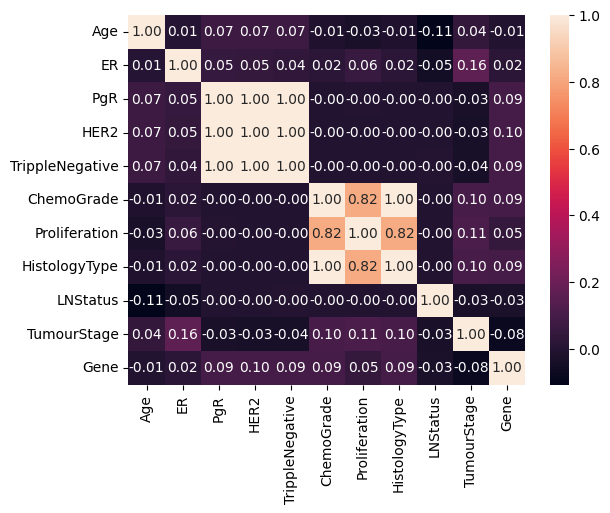

In [3]:
min_df = X.iloc[:, :11]
coorrelation_matrix = min_df.corr()
sns.heatmap(coorrelation_matrix, annot=True, fmt='.2f')
'''
correlation matrix
no columns are meaningfully correlated with Gene
'''

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Split data into rows with and without missing values
df_no_missing_gene = X[X['Gene'] != 999]

# pca of mri data
pca_mri = df_no_missing_gene.iloc[:, 11:]
normal_mri_data_scaled = scaler.fit_transform(pca_mri)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(normal_mri_data_scaled)

# add pca data to feats
# first 10 columns are gene data
feats = df_no_missing_gene.iloc[:, :10]
feats['pca_1'] = X_pca[:, 0]
feats['pca_2'] = X_pca[:, 1]

# feats = df_no_missing_gene.drop(columns=['Gene'])
label = df_no_missing_gene['Gene']

# Split data into train and test sets
scaled_feats = scaler.fit_transform(feats)
feat_x, test_x, train_y, test_y = train_test_split(scaled_feats, label, test_size=0.2, random_state=42)


In [5]:
# logistic regression
log_clf = LogisticRegression()
log_clf.fit(feat_x, train_y)

# Predict missing values
predictions = log_clf.predict(test_x)
score = accuracy_score(test_y, predictions)
print(f"Logistic reg: {score}")

# rand forest
from sklearn.ensemble import RandomForestClassifier
rand_forest_clf = RandomForestClassifier()
rand_forest_clf.fit(feat_x, train_y)
predictions = rand_forest_clf.predict(test_x)
score = accuracy_score(test_y, predictions)
print(f"Random forest: {score}")

# knn
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=55)
knn_clf.fit(feat_x, train_y)

predictions = knn_clf.predict(test_x)
score = accuracy_score(test_y, predictions)
print(f"KNN: {score}")

Logistic reg: 0.7142857142857143
Random forest: 0.5873015873015873
KNN: 0.6507936507936508


In [ ]:
### USE Logistic Regression to predict missing values
clf_missing_gene = LogisticRegression()

# train with entire non missing dataset
train = X[X['Gene'] != 999]
train_y = train['Gene']

feat_mri = train.iloc[:, 11:]
feat_normal_mri_data_scaled = scaler.fit_transform(feat_mri)
pca = PCA(n_components=2)
feat_pca = pca.fit_transform(feat_normal_mri_data_scaled)

# drop gene column
feat = train.iloc[:, :10]
feat['pca_1'] = feat_pca[:, 0]
feat['pca_2'] = feat_pca[:, 1]

# train
feat = scaler.fit_transform(feat)
clf_missing_gene.fit(feat, train_y)

'''
Compute missing values
'''
target = X[X['Gene'] == 999]
target = target.drop('Gene', axis=1)
target_mri = target.iloc[:, 11:]
target_normal_mri_data_scaled = scaler.fit_transform(target_mri)
pca = PCA(n_components=2)
target_pca = pca.fit_transform(target_normal_mri_data_scaled)

target = target.iloc[:, :10]
target['pca_1'] = target_pca[:, 0]
target['pca_2'] = target_pca[:, 1]

target = scaler.fit_transform(target)
gene_pred = clf_missing_gene.predict(target)

# fill in missing values
X.loc[X['Gene'] == 999, 'Gene'] = gene_pred

# write back
original_df['Gene'] = X['Gene']
original_df.to_csv('altered_csv/gene_predicted.csv', index=False)

In [7]:
# data segmentation
X_mri = X.iloc[:, 11:]
X_non_mri = X.iloc[:, :11]
mandatory_features = ['ER', 'HER2', 'Gene']
mandatory_features_indices = [X.columns.get_loc(feature) for feature in mandatory_features]

### Feature Selection

In [8]:
#split
X_train, X_test, y_train, y_test = train_test_split(X, rgr_y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# select k best
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(score_func=f_regression, k=10)  # Keep top 50 features
X_train_reduced = selector.fit_transform(X_train_scaled, y_train)
X_test_reduced = selector.transform(X_test_scaled)

In [10]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_reduced, y_train)

RandomForestRegressor(random_state=42)

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
predictions = model.predict(X_test_reduced)
mae = mean_absolute_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

print(f"MAE: {mae}, RMSE: {rmse}, R2: {r2}")

MAE: 22.40999999996375, RMSE: 28.90445058662934, R2: -0.04687584472362483


/Users/stephen/Library/Caches/pypoetry/virtualenvs/labs-env-NHQiDXzZ-py3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [12]:
# Manifold Learning
from sklearn.manifold import TSNE, Isomap
import matplotlib.pyplot as plt 

tsne = TSNE(n_components=1, random_state=42) 
X_mri_tsne = tsne.fit_transform(X_mri)

# join non mri woth x_tsne
X_tsne = np.c_[X_non_mri, X_mri_tsne]
X_tsne.shape


(400, 12)

In [13]:
# MANIFOLD training
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

Xs_manifold_train, Xs_manifold_test, y_manifold_train, y_manifold_test = train_test_split(X_tsne, rgr_y, test_size=0.2, random_state=42)

svr = SVR(C=6, gamma=0.1, kernel='rbf')
svr.fit(Xs_manifold_train, y_manifold_train)

y_pred = svr.predict(Xs_manifold_test)
mae = np.mean(np.abs(y_manifold_test - y_pred))

mse = mean_squared_error(y_manifold_test, y_pred)
print('Test MAE:', mae)
print('Test MSE:', mse)

mae_normalized = mae / rgr_y.mean()
print(f"Normalized MAE: {mae_normalized}")


Test MAE: 21.57951157922472
Test MSE: 836.2633219020561
Normalized MAE: 0.385346987475271


In [14]:
# check MRI data normality
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
def check_normality(data, alpha=0.05):
    """
    Comprehensive check for normality of features using multiple methods.
    
    Parameters:
    data: pandas DataFrame or numpy array
    alpha: significance level for statistical tests
    
    Returns:
    dict: Results of normality tests for each feature
    """
    # Convert to DataFrame if numpy array
    if isinstance(data, np.ndarray):
        data = pd.DataFrame(data)
    
    results = {}
    
    for column in data.columns:
        feature_data = data[column].dropna()
        
        # 1. Shapiro-Wilk test
        shapiro_stat, shapiro_p = stats.shapiro(feature_data)
        
        # 2. D'Agostino-Pearson test
        agostino_stat, agostino_p = stats.normaltest(feature_data)
        
        # 3. Basic statistics
        skewness = stats.skew(feature_data)
        kurtosis = stats.kurtosis(feature_data)
        
        # Store results
        results[column] = {
            'shapiro_test': {
                'statistic': shapiro_stat,
                'p_value': shapiro_p,
                'is_normal': shapiro_p > alpha
            },
            'agostino_test': {
                'statistic': agostino_stat,
                'p_value': agostino_p,
                'is_normal': agostino_p > alpha
            },
            'skewness': skewness,
            'kurtosis': kurtosis
        }
    
    return results

def print_normality_summary(results):
    """
    Print a human-readable summary of normality test results.
    
    Parameters:
    results: dict from check_normality function
    """
    print("\nNormality Test Summary:")
    print("-" * 80)
    
    for column, tests in results.items():
        print(f"\nFeature: {column}")
        print("  Shapiro-Wilk Test:")
        print(f"    - p-value: {tests['shapiro_test']['p_value']:.4f}")
        print(f"    - Normal: {tests['shapiro_test']['is_normal']}")
        
        print("  D'Agostino-Pearson Test:")
        print(f"    - p-value: {tests['agostino_test']['p_value']:.4f}")
        print(f"    - Normal: {tests['agostino_test']['is_normal']}")
        
        print("  Distribution Characteristics:")
        print(f"    - Skewness: {tests['skewness']:.4f}")
        print(f"    - Kurtosis: {tests['kurtosis']:.4f}")
        print("-" * 80)

def plot_normality_checks(data, figsize=(15, 5)):
    """
    Create visual checks for normality including histogram, Q-Q plot, and box plot.
    
    Parameters:
    data: pandas DataFrame or numpy array
    figsize: tuple for figure size
    """
    if isinstance(data, np.ndarray):
        data = pd.DataFrame(data)
    
    for column in data.columns:
        feature_data = data[column].dropna()
        
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        fig.suptitle(f'Normality Checks for {column}')
        
        # 1. Histogram with KDE
        sns.histplot(feature_data, kde=True, ax=axes[0])
        axes[0].set_title('Histogram with KDE')
        
        # # 2. Q-Q plot
        # stats.probplot(feature_data, dist="norm", plot=axes[1])
        # axes[1].set_title('Q-Q Plot')
        
        # 3. Box plot
        sns.boxplot(y=feature_data, ax=axes[1])
        axes[1].set_title('Box Plot')
        
        plt.tight_layout()
        plt.show()

In [15]:
from pprint import pprint

mri_data = X.iloc[:, 11:]

mri_data.head()

normality_results = check_normality(mri_data)

cols = list(normality_results.keys())

printRes = {}

for col in cols[:5]:
    printRes[col] = normality_results[col]

print_normality_summary(printRes)



Normality Test Summary:
--------------------------------------------------------------------------------

Feature: original_shape_Elongation
  Shapiro-Wilk Test:
    - p-value: 0.0000
    - Normal: False
  D'Agostino-Pearson Test:
    - p-value: 0.0000
    - Normal: False
  Distribution Characteristics:
    - Skewness: -0.7848
    - Kurtosis: 0.2628
--------------------------------------------------------------------------------

Feature: original_shape_Flatness
  Shapiro-Wilk Test:
    - p-value: 0.0000
    - Normal: False
  D'Agostino-Pearson Test:
    - p-value: 0.0000
    - Normal: False
  Distribution Characteristics:
    - Skewness: -0.1681
    - Kurtosis: -0.8080
--------------------------------------------------------------------------------

Feature: original_shape_LeastAxisLength
  Shapiro-Wilk Test:
    - p-value: 0.0000
    - Normal: False
  D'Agostino-Pearson Test:
    - p-value: 0.0000
    - Normal: False
  Distribution Characteristics:
    - Skewness: 1.8392
    - Kurto

In [16]:
'''
Find MRI columns that follow a normal distribution 
'''
## keep only normal data and run PCA
def get_normal_cols(normality_results):
  normal_cols = []
  for col, tests in normality_results.items():
    if tests['shapiro_test']['is_normal'] or tests['agostino_test']['is_normal']:
      normal_cols.append(col)
  return normal_cols
normal_cols = get_normal_cols(normality_results)

In [17]:
'''
Run PCA on MRI data
'''

normal_mri_data = mri_data[normal_cols]

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
normal_mri_data_scaled = scaler.fit_transform(normal_mri_data)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(normal_mri_data_scaled)



In [18]:
# join original data with pca data
# manifold on normal data
X_mri_normal = X_mri[normal_cols]
X_mri_normal_tsne = tsne.fit_transform(X_mri_normal)

X_pca_df = np.c_[X_non_mri, X_pca, X_mri_normal_tsne]
X_pca_df.shape

(400, 14)

In [19]:
 
Xs_selected_pca_train, Xs_selected_pca_test, y_selected_pca_train, y_selected_pca_test = train_test_split(X_pca_df, rgr_y, test_size=0.2, random_state=42)

svr = SVR(C=6, gamma=0.1, kernel='rbf')
svr.fit(Xs_selected_pca_train, y_selected_pca_train)

y_pred = svr.predict(Xs_selected_pca_test)

mae = mean_absolute_error(y_selected_pca_test, y_pred)

mse = mean_squared_error(y_selected_pca_test, y_pred)

print('Test MAE:', mae)
print('Test MSE:', mse)

Test MAE: 21.790114691767265
Test MSE: 837.9550822197732


In [20]:
# Todo:
# feature selection
### wrapper method

# try more things with imputation
## try random fill of missing values
## try dropping all
## try probabilistic imputation


